# Recommender Systems Challenge, 2023/2024 @ PoliMi

# Introduction

## Problem Description
The application domain is book recommendation. The datasets contain interactions of users with books, in particular, if the user attributed to the book a rating of at least 4. The main goal of the competition is to discover which items (books) a user will interact with.

The datasets includes around 600k interactions, 13k users, 22k items (books).
The training-test split is done via random holdout, 80% training, 20% test.
The goal is to recommend a list of 10 potentially relevant items for each user.


## Datasets
All files are comma-separated (columns are separated with ',' ).

- **data_train.csv**:
Contains the training set, describing implicit preferences expressed by the users.
    - **user_id** : identifier of the user
    - **item_id** : identifier of the item (Book)
    - **data** : "1.0" if the user liked the book attributing it a rating of at least 4.


- **data_target_users_test.csv**:
Contains the ids of the users that should appear in your submission file.
The submission file should contain all and only these users.

- **sample_submission.csv**:
A sample submission file in the correct format: [user_id],[ordered list of recommended items].
Be careful with the spaces and be sure to recommend the correct number of items to every user.

# Requirements

The working environment and the required libraries are defined here.

In [1]:
# Import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps # creation of sparse matrix
import matplotlib.pyplot as pyplot # plot
import tensorflow as tf

from tqdm import tqdm

from scipy.stats import uniform, loguniform

from Recommenders.Recommender_import_list import *

from Data_manager.DataSplitter_leave_k_out import DataSplitter_leave_k_out
from Recommenders.Incremental_Training_Early_Stopping import Incremental_Training_Early_Stopping
from Recommenders.BaseCBFRecommender import BaseItemCBFRecommender, BaseUserCBFRecommender
from Evaluation.Evaluator import EvaluatorHoldout
import traceback, os

C:\Users\zheng\.conda\envs\RecSysFramework\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
%load_ext Cython

# Data Preprocessing

In [3]:
# Handle the input file
input_file = open('Input/data_train.csv', 'r')
type(input_file)

_io.TextIOWrapper

In [4]:
# Build the dataframe from the input file
input_df = pd.read_csv(
    filepath_or_buffer=input_file,
    dtype={0:int, 1:int, 2:int},
    names=['user_id','item_id','data'],
    header=0
)

input_df.shape

(478730, 3)

In [5]:
# Show the first rows of the dataframe
input_df.head(n=10)

,user_id,item_id,data
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
5,1,187,1
6,1,205,1
7,1,222,1
8,1,237,1
9,1,354,1


In [6]:
# Create arrays of unique user_ids and item_ids
arr_users = input_df["user_id"].unique()
arr_items = input_df["item_id"].unique()

print(arr_users)
print(arr_items)

[    1     2     3 ... 13022 13023 13024]
[    7    15    16 ... 22317 22339 21466]


In [7]:
# Show some statistics
n_users = len(arr_users)
n_items = len(arr_items)
n_interactions = len(input_df)

print("Average interaction per user {:.2f}".format(n_interactions/n_users))
print("Average interaction per item {:.2f}".format(n_interactions/n_items))
print("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Average interaction per user 37.88
Average interaction per item 21.54
Sparsity 99.83 %


In [8]:
print("Number of users\t {}, Number of items\t {} \n".format(n_users, n_items))
print("Max ID users\t {}, Max ID items\t {} \n".format(max(arr_users), max(arr_items)))

Number of users	 12638, Number of items	 22222 

Max ID users	 13024, Max ID items	 22347 



In [9]:
# # Remove empty indices, create a new mapping

# mapped_id, original_id = pd.factorize(input_df["user_id"].unique())
# user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

# mapped_id, original_id = pd.factorize(input_df["item_id"].unique())
# item_original_ID_to_index = pd.Series(mapped_id, index=original_id)


# original_item_ID = 980
# print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))

In [10]:
# # Replace the IDs in the dataframe

# input_df["user_id"] = input_df["user_id"].map(user_original_ID_to_index)
# input_df["item_id"] = input_df["item_id"].map(item_original_ID_to_index)


# input_df.head(n=10)

# Matrix Conversion

In [11]:
# Build the COO matrix with the COO constructor: (data, (row, column))
URM_all = sps.coo_matrix(
    (input_df["data"].values,
    (input_df["user_id"].values, input_df["item_id"].values))
)

URM_all

<13025x22348 sparse matrix of type '<class 'numpy.int32'>'
	with 478730 stored elements in COOrdinate format>

In [12]:
# Convert the matrix to Compressed Sparse Row format
URM_all = URM_all.tocsr()

URM_all

<13025x22348 sparse matrix of type '<class 'numpy.intc'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
# Compute the item popularity as the number of interaction in each column

# numpy.ediff1d(): calculate the differences between consecutive elements of an array.
# (scipy) indptr maps the elements of data and indices to the rows of the sparse matrix.
item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([   0, 1581, 1764, ...,    3,    5,    2])

In [14]:
# Sort the popularity array
item_popularity = np.sort(item_popularity)
item_popularity

array([   0,    0,    0, ..., 1581, 1666, 1764])

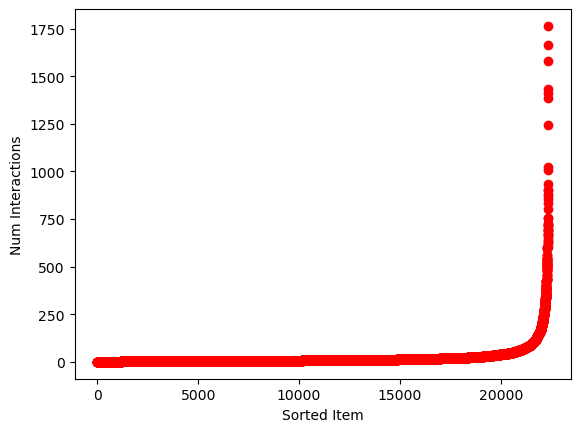

In [15]:
# Plot the correlation between sorted items and the number of interactions.
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [16]:
# Statistics
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Average per-item interactions over the whole dataset 21.42
Average per-item interactions for the top 10% popular items 122.73
Average per-item interactions for the least 10% popular items 2.18
Average per-item interactions for the median 10% popular items 8.25
Number of items with zero interactions 126


In [17]:
# Compute the user activity as the number of interaction in each row
user_activity = np.ediff1d(URM_all.indptr)
user_activity = np.sort(user_activity)
user_activity

array([   0,    0,    0, ...,  729,  824, 1351])

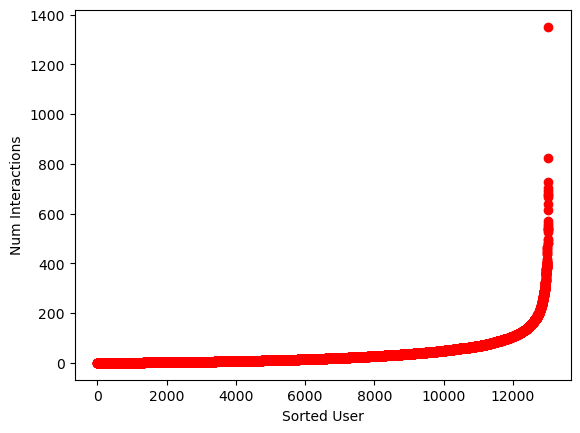

In [18]:
# Plot the correlation between sorted users and number of interactions
pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions')
pyplot.xlabel('Sorted User')
pyplot.show()

# Evaluation of the recommender

In [19]:
def _get_instance(recommender_class, URM_train, ICM_all, UCM_all):

    if issubclass(recommender_class, BaseItemCBFRecommender):
        recommender_object = recommender_class(URM_train, ICM_all)
    elif issubclass(recommender_class, BaseUserCBFRecommender):
        recommender_object = recommender_class(URM_train, UCM_all)
    else:
        recommender_object = recommender_class(URM_train)

    return recommender_object# Define the train-test splitting ratio

In [20]:
train_test_split = 0.85

In [21]:
# Import Evaluators
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [22]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = train_test_split)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = train_test_split)


evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10], exclude_seen = True)
evaluator = EvaluatorHoldout(URM_test, cutoff_list=[10], exclude_seen = True)

EvaluatorHoldout: Ignoring 3424 (26.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 3159 (24.3%) Users that have less than 1 test interactions


Content-based: URM in csr, ICM in csr

Collaborative filtering: URM in csr

FunkSVD: URM in coo

AsySVD: URM in coo


In [23]:
earlystopping_keywargs = {"validation_every_n": 5,
                        "stop_on_validation": True,
                        "evaluator_object": EvaluatorHoldout(URM_validation, [10], exclude_seen=True),
                        "lower_validations_allowed": 5,
                        "validation_metric": "MAP",
}

EvaluatorHoldout: Ignoring 3424 (26.3%) Users that have less than 1 test interactions


In [24]:
output_root_path = "./result_experiments/"

# If directory does not exist, create
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)


logFile = open(output_root_path + "result_all_algorithms.txt", "a")

In [25]:
recommender_class_list = [
    Random,
    TopPop,
    GlobalEffects,
    SLIMElasticNetRecommender,
    UserKNNCFRecommender,
    IALSRecommender,
    MatrixFactorization_BPR_Cython,
    # MatrixFactorization_FunkSVD_Cython,
    MatrixFactorization_AsySVD_Cython,
    EASE_R_Recommender,
    ItemKNNCFRecommender,
    P3alphaRecommender,
    SLIM_BPR_Cython,
    RP3betaRecommender,
    PureSVDRecommender,
    NMFRecommender,
    UserKNNCBFRecommender,
    ItemKNNCBFRecommender,
    UserKNN_CFCBF_Hybrid_Recommender,
    ItemKNN_CFCBF_Hybrid_Recommender,
    LightFMCFRecommender,
    LightFMUserHybridRecommender,
    LightFMItemHybridRecommender,
]

In [26]:
ICM_all = np.array([])
UCM_all = np.array([])

In [ ]:
for recommender_class in tqdm(recommender_class_list):

    try:

        print("Algorithm: {}".format(recommender_class))

        recommender_object = _get_instance(recommender_class, URM_train, ICM_all, UCM_all)

        if isinstance(recommender_object, Incremental_Training_Early_Stopping):
            fit_params = {"epochs": 15, **earlystopping_keywargs}
        else:
            fit_params = {}

        recommender_object.fit(**fit_params)

        results_run_1, results_run_string_1 = evaluator.evaluateRecommender(recommender_object)

        recommender_object.save_model(output_root_path, file_name = "temp_model.zip")

        recommender_object = _get_instance(recommender_class, URM_train, ICM_all, UCM_all)
        recommender_object.load_model(output_root_path, file_name = "temp_model.zip")

        os.remove(output_root_path + "temp_model.zip")

        results_run_2, results_run_string_2 = evaluator.evaluateRecommender(recommender_object)

        if recommender_class not in [Random]:
            assert results_run_1.equals(results_run_2)

        print("Algorithm: {}, results: \n{}".format(recommender_class, results_run_string_1))
        logFile.write("Algorithm: {}, results: \n{}\n".format(recommender_class, results_run_string_1))
        logFile.flush()


    except Exception as e:
        traceback.print_exc()
        logFile.write("Algorithm: {} - Exception: {}\n".format(recommender_class, str(e)))
        logFile.flush()

  0%|                                                                                                | 0/22 [00:00<?, ?it/s]

Algorithm: <class 'Recommenders.NonPersonalizedRecommender.Random'>
RandomRecommender: URM Detected 703 ( 5.4%) users with no interactions.
RandomRecommender: URM Detected 313 ( 1.4%) items with no interactions.
EvaluatorHoldout: Processed 9866 (100.0%) in 5.79 sec. Users per second: 1705
RandomRecommender: Saving model in file './result_experiments/temp_model.zip'
RandomRecommender: Saving complete
RandomRecommender: URM Detected 703 ( 5.4%) users with no interactions.
RandomRecommender: URM Detected 313 ( 1.4%) items with no interactions.
RandomRecommender: Loading model from file './result_experiments/temp_model.zip'
RandomRecommender: Loading complete
EvaluatorHoldout: Processed 9866 (100.0%) in 5.80 sec. Users per second: 1702


  5%|████                                                                                    | 1/22 [00:11<04:04, 11.62s/it]

Algorithm: <class 'Recommenders.NonPersonalizedRecommender.Random'>, results: 
CUTOFF: 10 - PRECISION: 0.0003446, PRECISION_RECALL_MIN_DEN: 0.0006922, RECALL: 0.0005970, MAP: 0.0000895, MAP_MIN_DEN: 0.0001982, MRR: 0.0008948, NDCG: 0.0004832, F1: 0.0004370, HIT_RATE: 0.0034462, ARHR_ALL_HITS: 0.0008948, NOVELTY: 0.0068600, AVERAGE_POPULARITY: 0.0118872, DIVERSITY_MEAN_INTER_LIST: 0.9995552, DIVERSITY_HERFINDAHL: 0.9999454, COVERAGE_ITEM: 0.9885896, COVERAGE_ITEM_HIT: 0.0015214, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.0026104, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.7389694, SHANNON_ENTROPY: 14.2798848, RATIO_DIVERSITY_HERFINDAHL: 1.0003072, RATIO_DIVERSITY_GINI: 2.1460907, RATIO_SHANNON_ENTROPY: 1.1005257, RATIO_AVERAGE_POPULARITY: 0.1009350, RATIO_NOVELTY: 0.4449276, 

Algorithm: <class 'Recommenders.NonPersonalizedRecommender.TopPop'>
TopPopRecommender: URM Detected 703 ( 5.4%) users with no interactions.
TopPopRecommender: URM Detected 313 ( 1.4%) it

  9%|████████                                                                                | 2/22 [00:22<03:41, 11.06s/it]

Algorithm: <class 'Recommenders.NonPersonalizedRecommender.TopPop'>, results: 
CUTOFF: 10 - PRECISION: 0.0226941, PRECISION_RECALL_MIN_DEN: 0.0500740, RECALL: 0.0456202, MAP: 0.0088857, MAP_MIN_DEN: 0.0192084, MRR: 0.0737662, NDCG: 0.0391560, F1: 0.0303102, HIT_RATE: 0.1911616, ARHR_ALL_HITS: 0.0808880, NOVELTY: 0.0038302, AVERAGE_POPULARITY: 0.7277142, DIVERSITY_MEAN_INTER_LIST: 0.1484619, DIVERSITY_HERFINDAHL: 0.9148447, COVERAGE_ITEM: 0.0010292, COVERAGE_ITEM_HIT: 0.0008054, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.1447985, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.0005417, SHANNON_ENTROPY: 3.6444576, RATIO_DIVERSITY_HERFINDAHL: 0.9151757, RATIO_DIVERSITY_GINI: 0.0015733, RATIO_SHANNON_ENTROPY: 0.2808720, RATIO_AVERAGE_POPULARITY: 6.1790469, RATIO_NOVELTY: 0.2484205, 

Algorithm: <class 'Recommenders.NonPersonalizedRecommender.GlobalEffects'>
GlobalEffectsRecommender: URM Detected 703 ( 5.4%) users with no interactions.
GlobalEffectsRecommender: URM Det

 14%|████████████                                                                            | 3/22 [00:29<02:59,  9.47s/it]

Algorithm: <class 'Recommenders.NonPersonalizedRecommender.GlobalEffects'>, results: 
CUTOFF: 10 - PRECISION: 0.0000811, PRECISION_RECALL_MIN_DEN: 0.0001464, RECALL: 0.0001130, MAP: 0.0000222, MAP_MIN_DEN: 0.0000392, MRR: 0.0002223, NDCG: 0.0001067, F1: 0.0000944, HIT_RATE: 0.0008109, ARHR_ALL_HITS: 0.0002223, NOVELTY: 0.0075356, AVERAGE_POPULARITY: 0.0026936, DIVERSITY_MEAN_INTER_LIST: 0.2389302, DIVERSITY_HERFINDAHL: 0.9238906, COVERAGE_ITEM: 0.0062198, COVERAGE_ITEM_HIT: 0.0003132, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.0006142, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.0005922, SHANNON_ENTROPY: 3.9380099, RATIO_DIVERSITY_HERFINDAHL: 0.9242249, RATIO_DIVERSITY_GINI: 0.0017199, RATIO_SHANNON_ENTROPY: 0.3034955, RATIO_AVERAGE_POPULARITY: 0.0228717, RATIO_NOVELTY: 0.4887464, 

Algorithm: <class 'Recommenders.SLIM.SLIMElasticNetRecommender.SLIMElasticNetRecommender'>
SLIMElasticNetRecommender: URM Detected 703 ( 5.4%) users with no interactions.
SLIMElast

 18%|████████████████                                                                        | 4/22 [03:39<24:09, 80.55s/it]

Algorithm: <class 'Recommenders.SLIM.SLIMElasticNetRecommender.SLIMElasticNetRecommender'>, results: 
CUTOFF: 10 - PRECISION: 0.0000608, PRECISION_RECALL_MIN_DEN: 0.0000804, RECALL: 0.0000582, MAP: 0.0000194, MAP_MIN_DEN: 0.0000215, MRR: 0.0001935, NDCG: 0.0000702, F1: 0.0000595, HIT_RATE: 0.0006081, ARHR_ALL_HITS: 0.0001935, NOVELTY: 0.0073029, AVERAGE_POPULARITY: 0.0033762, DIVERSITY_MEAN_INTER_LIST: 0.2411967, DIVERSITY_HERFINDAHL: 0.9241172, COVERAGE_ITEM: 0.0038482, COVERAGE_ITEM_HIT: 0.0002237, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.0004607, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.0005871, SHANNON_ENTROPY: 3.9363720, RATIO_DIVERSITY_HERFINDAHL: 0.9244516, RATIO_DIVERSITY_GINI: 0.0017050, RATIO_SHANNON_ENTROPY: 0.3033693, RATIO_AVERAGE_POPULARITY: 0.0286670, RATIO_NOVELTY: 0.4736551, 

Algorithm: <class 'Recommenders.KNN.UserKNNCFRecommender.UserKNNCFRecommender'>
UserKNNCFRecommender: URM Detected 703 ( 5.4%) users with no interactions.
UserKNNCF

 23%|████████████████████                                                                    | 5/22 [03:48<15:31, 54.81s/it]

Algorithm: <class 'Recommenders.KNN.UserKNNCFRecommender.UserKNNCFRecommender'>, results: 
CUTOFF: 10 - PRECISION: 0.0358301, PRECISION_RECALL_MIN_DEN: 0.0599113, RECALL: 0.0510317, MAP: 0.0160228, MAP_MIN_DEN: 0.0269986, MRR: 0.1141930, NDCG: 0.0549725, F1: 0.0421007, HIT_RATE: 0.2516724, ARHR_ALL_HITS: 0.1347382, NOVELTY: 0.0053195, AVERAGE_POPULARITY: 0.1896800, DIVERSITY_MEAN_INTER_LIST: 0.9814999, DIVERSITY_HERFINDAHL: 0.9981400, COVERAGE_ITEM: 0.5070700, COVERAGE_ITEM_HIT: 0.0421067, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.1906334, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.1234549, SHANNON_ENTROPY: 11.1416503, RATIO_DIVERSITY_HERFINDAHL: 0.9985012, RATIO_DIVERSITY_GINI: 0.3585337, RATIO_SHANNON_ENTROPY: 0.8586675, RATIO_AVERAGE_POPULARITY: 1.6105796, RATIO_NOVELTY: 0.3450147, 

Algorithm: <class 'Recommenders.MatrixFactorization.IALSRecommender.IALSRecommender'>
IALSRecommender: URM Detected 703 ( 5.4%) users with no interactions.
IALSRecommender: U

 27%|████████████████████████                                                                | 6/22 [04:38<14:09, 53.07s/it]

Algorithm: <class 'Recommenders.MatrixFactorization.IALSRecommender.IALSRecommender'>, results: 
CUTOFF: 10 - PRECISION: 0.0450334, PRECISION_RECALL_MIN_DEN: 0.0946873, RECALL: 0.0858986, MAP: 0.0196295, MAP_MIN_DEN: 0.0413384, MRR: 0.1449314, NDCG: 0.0786960, F1: 0.0590888, HIT_RATE: 0.3295155, ARHR_ALL_HITS: 0.1682088, NOVELTY: 0.0043490, AVERAGE_POPULARITY: 0.3937965, DIVERSITY_MEAN_INTER_LIST: 0.9002799, DIVERSITY_HERFINDAHL: 0.9900189, COVERAGE_ITEM: 0.0171380, COVERAGE_ITEM_HIT: 0.0117684, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.2495969, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.0048919, SHANNON_ENTROPY: 7.1848843, RATIO_DIVERSITY_HERFINDAHL: 0.9903771, RATIO_DIVERSITY_GINI: 0.0142070, RATIO_SHANNON_ENTROPY: 0.5537265, RATIO_AVERAGE_POPULARITY: 3.3437402, RATIO_NOVELTY: 0.2820656, 

Algorithm: <class 'Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython.MatrixFactorization_BPR_Cython'>
MatrixFactorization_BPR_Cython_Recommender: URM De

Traceback (most recent call last):
  File "C:\Users\zheng\AppData\Local\Temp\ipykernel_24296\1019192044.py", line 14, in <module>
    recommender_object.fit(**fit_params)
  File "D:\Uni\Magistrale\Recommender Systems\23-24 challenge\Recommenders\MatrixFactorization\Cython\MatrixFactorization_Cython.py", line 169, in fit
    super(MatrixFactorization_BPR_Cython, self).fit(**key_args)
  File "D:\Uni\Magistrale\Recommender Systems\23-24 challenge\Recommenders\MatrixFactorization\Cython\MatrixFactorization_Cython.py", line 91, in fit
    self.cythonEpoch = MatrixFactorization_Cython_Epoch(URM_train_positive,
  File "MatrixFactorization_Cython_Epoch.pyx", line 99, in MatrixFactorization_Cython_Epoch.MatrixFactorization_Cython_Epoch.__init__
TypeError: __init__() got an unexpected keyword argument 'WARP_neg_item_attempts'
Traceback (most recent call last):
  File "C:\Users\zheng\AppData\Local\Temp\ipykernel_24296\1019192044.py", line 14, in <module>
    recommender_object.fit(**fit_params)
 

EASE_R_Recommender: Fitting model... done in 1.48 min
EvaluatorHoldout: Processed 9866 (100.0%) in 6.22 sec. Users per second: 1585
EASE_R_Recommender: Saving model in file './result_experiments/temp_model.zip'
EASE_R_Recommender: Saving complete
EASE_R_Recommender: URM Detected 703 ( 5.4%) users with no interactions.
EASE_R_Recommender: URM Detected 313 ( 1.4%) items with no interactions.
EASE_R_Recommender: Loading model from file './result_experiments/temp_model.zip'
EASE_R_Recommender: Loading complete
EvaluatorHoldout: Processed 9866 (100.0%) in 6.27 sec. Users per second: 1573


 41%|████████████████████████████████████                                                    | 9/22 [07:32<12:07, 55.98s/it]

Algorithm: <class 'Recommenders.EASE_R.EASE_R_Recommender.EASE_R_Recommender'>, results: 
CUTOFF: 10 - PRECISION: 0.0555038, PRECISION_RECALL_MIN_DEN: 0.1236455, RECALL: 0.1136958, MAP: 0.0250503, MAP_MIN_DEN: 0.0560137, MRR: 0.1803208, NDCG: 0.1019966, F1: 0.0745929, HIT_RATE: 0.3970201, ARHR_ALL_HITS: 0.2119168, NOVELTY: 0.0043823, AVERAGE_POPULARITY: 0.4308465, DIVERSITY_MEAN_INTER_LIST: 0.8584360, DIVERSITY_HERFINDAHL: 0.9858349, COVERAGE_ITEM: 0.1098532, COVERAGE_ITEM_HIT: 0.0267585, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.3007294, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.0101962, SHANNON_ENTROPY: 7.6414638, RATIO_DIVERSITY_HERFINDAHL: 0.9861916, RATIO_DIVERSITY_GINI: 0.0296114, RATIO_SHANNON_ENTROPY: 0.5889142, RATIO_AVERAGE_POPULARITY: 3.6583325, RATIO_NOVELTY: 0.2842273, 

Algorithm: <class 'Recommenders.KNN.ItemKNNCFRecommender.ItemKNNCFRecommender'>
ItemKNNCFRecommender: URM Detected 703 ( 5.4%) users with no interactions.
ItemKNNCFRecommender:

 45%|███████████████████████████████████████▌                                               | 10/22 [07:45<09:19, 46.65s/it]

Algorithm: <class 'Recommenders.KNN.ItemKNNCFRecommender.ItemKNNCFRecommender'>, results: 
CUTOFF: 10 - PRECISION: 0.0578553, PRECISION_RECALL_MIN_DEN: 0.1255292, RECALL: 0.1144394, MAP: 0.0266161, MAP_MIN_DEN: 0.0584272, MRR: 0.1858320, NDCG: 0.1052864, F1: 0.0768558, HIT_RATE: 0.4012771, ARHR_ALL_HITS: 0.2213674, NOVELTY: 0.0047263, AVERAGE_POPULARITY: 0.2992546, DIVERSITY_MEAN_INTER_LIST: 0.9456209, DIVERSITY_HERFINDAHL: 0.9945525, COVERAGE_ITEM: 0.2260158, COVERAGE_ITEM_HIT: 0.0424647, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.3039539, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.0277693, SHANNON_ENTROPY: 9.0257205, RATIO_DIVERSITY_HERFINDAHL: 0.9949124, RATIO_DIVERSITY_GINI: 0.0806467, RATIO_SHANNON_ENTROPY: 0.6955965, RATIO_AVERAGE_POPULARITY: 2.5409811, RATIO_NOVELTY: 0.3065415, 

Algorithm: <class 'Recommenders.GraphBased.P3alphaRecommender.P3alphaRecommender'>
P3alphaRecommender: URM Detected 703 ( 5.4%) users with no interactions.
P3alphaRecommender:

 50%|███████████████████████████████████████████▌                                           | 11/22 [07:59<07:05, 38.72s/it]

Algorithm: <class 'Recommenders.GraphBased.P3alphaRecommender.P3alphaRecommender'>, results: 
CUTOFF: 10 - PRECISION: 0.0284614, PRECISION_RECALL_MIN_DEN: 0.0555643, RECALL: 0.0493416, MAP: 0.0125448, MAP_MIN_DEN: 0.0262944, MRR: 0.0922543, NDCG: 0.0489930, F1: 0.0360997, HIT_RATE: 0.2132577, ARHR_ALL_HITS: 0.1068522, NOVELTY: 0.0059556, AVERAGE_POPULARITY: 0.0718191, DIVERSITY_MEAN_INTER_LIST: 0.9958088, DIVERSITY_HERFINDAHL: 0.9995708, COVERAGE_ITEM: 0.5397351, COVERAGE_ITEM_HIT: 0.0603186, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.1615355, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.2076652, SHANNON_ENTROPY: 12.4240395, RATIO_DIVERSITY_HERFINDAHL: 0.9999325, RATIO_DIVERSITY_GINI: 0.6030945, RATIO_SHANNON_ENTROPY: 0.9574990, RATIO_AVERAGE_POPULARITY: 0.6098185, RATIO_NOVELTY: 0.3862657, 

Algorithm: <class 'Recommenders.SLIM.Cython.SLIM_BPR_Cython.SLIM_BPR_Cython'>
SLIM_BPR_Recommender: URM Detected 703 ( 5.4%) users with no interactions.
SLIM_BPR_Recommend

 55%|███████████████████████████████████████████████▍                                       | 12/22 [08:44<06:42, 40.26s/it]

Algorithm: <class 'Recommenders.SLIM.Cython.SLIM_BPR_Cython.SLIM_BPR_Cython'>, results: 
CUTOFF: 10 - PRECISION: 0.0469897, PRECISION_RECALL_MIN_DEN: 0.1038143, RECALL: 0.0955144, MAP: 0.0209450, MAP_MIN_DEN: 0.0468252, MRR: 0.1548458, NDCG: 0.0861158, F1: 0.0629903, HIT_RATE: 0.3456315, ARHR_ALL_HITS: 0.1796895, NOVELTY: 0.0044297, AVERAGE_POPULARITY: 0.4607014, DIVERSITY_MEAN_INTER_LIST: 0.8033592, DIVERSITY_HERFINDAHL: 0.9803278, COVERAGE_ITEM: 0.2200644, COVERAGE_ITEM_HIT: 0.0217469, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.2618042, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.0200815, SHANNON_ENTROPY: 7.5810976, RATIO_DIVERSITY_HERFINDAHL: 0.9806825, RATIO_DIVERSITY_GINI: 0.0583200, RATIO_SHANNON_ENTROPY: 0.5842619, RATIO_AVERAGE_POPULARITY: 3.9118322, RATIO_NOVELTY: 0.2873030, 

Algorithm: <class 'Recommenders.GraphBased.RP3betaRecommender.RP3betaRecommender'>
RP3betaRecommender: URM Detected 703 ( 5.4%) users with no interactions.
RP3betaRecommender: U

 59%|███████████████████████████████████████████████████▍                                   | 13/22 [09:00<05:04, 33.89s/it]

Algorithm: <class 'Recommenders.GraphBased.RP3betaRecommender.RP3betaRecommender'>, results: 
CUTOFF: 10 - PRECISION: 0.0306913, PRECISION_RECALL_MIN_DEN: 0.0648493, RECALL: 0.0588898, MAP: 0.0115772, MAP_MIN_DEN: 0.0244130, MRR: 0.0813591, NDCG: 0.0490121, F1: 0.0403523, HIT_RATE: 0.2241030, ARHR_ALL_HITS: 0.0965425, NOVELTY: 0.0068413, AVERAGE_POPULARITY: 0.0567567, DIVERSITY_MEAN_INTER_LIST: 0.9948045, DIVERSITY_HERFINDAHL: 0.9994704, COVERAGE_ITEM: 0.5298908, COVERAGE_ITEM_HIT: 0.0515482, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.1697505, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.1837142, SHANNON_ENTROPY: 12.2048042, RATIO_DIVERSITY_HERFINDAHL: 0.9998320, RATIO_DIVERSITY_GINI: 0.5335367, RATIO_SHANNON_ENTROPY: 0.9406029, RATIO_AVERAGE_POPULARITY: 0.4819235, RATIO_NOVELTY: 0.4437118, 

Algorithm: <class 'Recommenders.MatrixFactorization.PureSVDRecommender.PureSVDRecommender'>
PureSVDRecommender: URM Detected 703 ( 5.4%) users with no interactions.
PureSV

 64%|███████████████████████████████████████████████████████▎                               | 14/22 [09:12<03:42, 27.83s/it]

Algorithm: <class 'Recommenders.MatrixFactorization.PureSVDRecommender.PureSVDRecommender'>, results: 
CUTOFF: 10 - PRECISION: 0.0448611, PRECISION_RECALL_MIN_DEN: 0.0925299, RECALL: 0.0839697, MAP: 0.0210870, MAP_MIN_DEN: 0.0436646, MRR: 0.1537089, NDCG: 0.0807553, F1: 0.0584794, HIT_RATE: 0.3260693, ARHR_ALL_HITS: 0.1795392, NOVELTY: 0.0046811, AVERAGE_POPULARITY: 0.2229210, DIVERSITY_MEAN_INTER_LIST: 0.9591598, DIVERSITY_HERFINDAHL: 0.9959063, COVERAGE_ITEM: 0.0371845, COVERAGE_ITEM_HIT: 0.0218364, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.2469866, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.0107302, SHANNON_ENTROPY: 8.3389427, RATIO_DIVERSITY_HERFINDAHL: 0.9962666, RATIO_DIVERSITY_GINI: 0.0311623, RATIO_SHANNON_ENTROPY: 0.6426677, RATIO_AVERAGE_POPULARITY: 1.8928300, RATIO_NOVELTY: 0.3036101, 

Algorithm: <class 'Recommenders.MatrixFactorization.NMFRecommender.NMFRecommender'>
NMFRecommender: URM Detected 703 ( 5.4%) users with no interactions.
NMFRecomme

 68%|███████████████████████████████████████████████████████████▎                           | 15/22 [09:27<02:49, 24.29s/it]

Algorithm: <class 'Recommenders.MatrixFactorization.NMFRecommender.NMFRecommender'>, results: 
CUTOFF: 10 - PRECISION: 0.0416278, PRECISION_RECALL_MIN_DEN: 0.0846507, RECALL: 0.0761133, MAP: 0.0188715, MAP_MIN_DEN: 0.0389653, MRR: 0.1402515, NDCG: 0.0733040, F1: 0.0538203, HIT_RATE: 0.3076221, ARHR_ALL_HITS: 0.1621962, NOVELTY: 0.0047905, AVERAGE_POPULARITY: 0.1945679, DIVERSITY_MEAN_INTER_LIST: 0.9648855, DIVERSITY_HERFINDAHL: 0.9964788, COVERAGE_ITEM: 0.0517272, COVERAGE_ITEM_HIT: 0.0208520, ITEMS_IN_GT: 0.7239574, COVERAGE_USER: 0.7574664, COVERAGE_USER_HIT: 0.2330134, USERS_IN_GT: 0.7574664, DIVERSITY_GINI: 0.0127535, SHANNON_ENTROPY: 8.5885315, RATIO_DIVERSITY_HERFINDAHL: 0.9968393, RATIO_DIVERSITY_GINI: 0.0370383, RATIO_SHANNON_ENTROPY: 0.6619031, RATIO_AVERAGE_POPULARITY: 1.6520833, RATIO_NOVELTY: 0.3107010, 

Algorithm: <class 'Recommenders.KNN.UserKNNCBFRecommender.UserKNNCBFRecommender'>
UserKNNCBFRecommender: URM Detected 703 ( 5.4%) users with no interactions.
UserKNNCBFRec

Traceback (most recent call last):
  File "C:\Users\zheng\AppData\Local\Temp\ipykernel_24296\1019192044.py", line 7, in <module>
    recommender_object = _get_instance(recommender_class, URM_train, ICM_all, UCM_all)
  File "C:\Users\zheng\AppData\Local\Temp\ipykernel_24296\389352537.py", line 6, in _get_instance
    recommender_object = recommender_class(URM_train, UCM_all)
  File "D:\Uni\Magistrale\Recommender Systems\23-24 challenge\Recommenders\KNN\UserKNNCBFRecommender.py", line 26, in __init__
    super(UserKNNCBFRecommender, self).__init__(URM_train, UCM_train, verbose = verbose)
  File "D:\Uni\Magistrale\Recommender Systems\23-24 challenge\Recommenders\BaseCBFRecommender.py", line 52, in __init__
    assert self.n_users == UCM_train.shape[0], "{}: URM_train has {} users but UCM_train has {}".format(self.RECOMMENDER_NAME, self.n_items, UCM_train.shape[0])
AssertionError: UserKNNCBFRecommender: URM_train has 22348 users but UCM_train has 0
Traceback (most recent call last):
  File

# Recommend items

In [ ]:
# Open the submission sample file
submission_sample = open('Input/data_target_users_test.csv', 'r')
type(submission_sample)

In [ ]:
# Read the dataframe
submission_df = pd.read_csv(filepath_or_buffer=submission_sample)
submission_df

In [ ]:
# Convert the user_id column to numpy list
user_list = submission_df['user_id'].to_numpy()
user_list

In [ ]:
# Extract the recommended items and write them in the dataframe

all_recommend = []

for i,id in tqdm(enumerate(user_list)):
    rec = recommender.recommend(id, cutoff=10)
    rec_list = rec
    rec_row = ' '.join(str(s) for s in rec_list)
    all_recommend.append(rec_row)

In [ ]:
all_recommend[:10]

In [ ]:
submission_df['item_list'] = all_recommend

In [ ]:
submission_df.head(10)

In [ ]:
# Export the dataframe on csv file
submission_df.to_csv('Output/ItemKNNCF.csv', index=False)

The user-item interaction value is not set in stone, you can weight that number according to some heuristics, for example you can weight less interactions of very popular items or users with huge profiles, this will impact how the item-item or user-user similarities are computed. For example: interaction value * log(popularity) or sqrt(popularity) or other ways, it is a heuristic so its success depends on the data and you may need to try a few.

Optimization of hyperparameters is very important in any prediction/classification/recommendation task. Sometimes spending a few extra hours optimizing is more efficient than spending a few days in searching for new ideas or models. Combine the two for the best outcome!